In [1]:
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import lightning.pytorch as pl
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
import tensorboard

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the root directory
root_directory = os.path.abspath(os.path.join(current_dir, '..'))

# Add the root directory to the system path
sys.path.append(root_directory)

# Verify the path addition
from helper_utils import *
from U_Net import *
import U_Net_helper_functions
from TIF_dataset import *
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
image_folder_paths = convert_backslashes_to_forward_slashes(r"C:\Users\Komputer\Documents\Hackaton_heidelberg\CellTrackingU-Net\data\train\augmented_data_Flue_N2DL-HeLa\imgs")
label_folder_paths = convert_backslashes_to_forward_slashes(r"C:\Users\Komputer\Documents\Hackaton_heidelberg\CellTrackingU-Net\data\train\augmented_data_Flue_N2DL-HeLa\labels")

image_paths =  list_files_in_folder(image_folder_paths)
label_paths =  list_files_in_folder(label_folder_paths)

validation_image_paths = image_paths[int(0.9 * len(image_paths)):]
validation_label_paths = label_paths[int(0.9 * len(image_paths)):]

image_paths =  image_paths[:int(0.9 * len(image_paths))]
label_paths =  label_paths[:int(0.9 * len(label_paths))]

In [3]:
train_dataset = TIF_dataset(image_paths, label_paths)
val_dataset = TIF_dataset(validation_image_paths, validation_label_paths)

# train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=15, persistent_workers=True)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=15, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [14]:
#train with pytorch lightning

sizes = [1, 16, 32, 64, 128, 256]

# logger = TensorBoardLogger("logs", name="U_Net")

lightning_model = UNet(sizes, kernel_size=7, padding = 3)

# trainer = pl.Trainer(max_epochs=3, logger=logger)
trainer = pl.Trainer(max_epochs=30)

trainer.fit(model = lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
# trainer.fit(model = lightning_model, train_dataloaders=train_dataloader)

# %load_ext tensorboard
# %tensorboard --logdir logs

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                | Params
-----------------------------------------------------
0 | bottom_path  | ModuleList          | 10.7 M
1 | top_path     | ModuleList          | 4.3 M 
2 | UpConvs      | ModuleList          | 349 K 
3 | pool         | MaxPool2d           | 0     
4 | bottom_block | Convolutional_Block | 9.6 M 
5 | loss_fn      | CrossEntropyLoss    | 0     
-----------------------------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.790    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 42/42 [01:07<00:00,  0.62it/s, v_num=41]   VALIDATION: Batch 0, loss 0.33939415216445923
   VALIDATION: Batch 1, loss 0.34003502130508423
   VALIDATION: Batch 2, loss 0.3335767984390259
   VALIDATION: Batch 3, loss 0.3341093957424164
   VALIDATION: Batch 4, loss 0.3366461992263794
Epoch 1: 100%|██████████| 42/42 [01:06<00:00,  0.63it/s, v_num=41]   VALIDATION: Batch 0, loss 0.46755337715148926
   VALIDATION: Batch 1, loss 0.44943395256996155
   VALIDATION: Batch 2, loss 0.4495463967323303
   VALIDATION: Batch 3, loss 0.43985891342163086
   VALIDATION: Batch 4, loss 0.44895103573799133
Epoch 2: 100%|██████████| 42/42 [01:06<00:00,  0.63it/s, v_num=41]   VALIDATION: Batch 0, loss 0.39270561933517456
   VALIDATION: Batch 1, loss 0.3820967674255371
   VALIDATION: Batch 2, loss 0.382712185382843
   VALIDATION: Batch 3, loss 0.3759828507900238
   VALIDATION: Batch 4, loss 0.3818719685077667
Epoch 3: 100%|██████████| 42/42 [01:06<00:00,  0.63it/s, v_num=41]   VALIDAT

c:\Users\Komputer\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [18]:
def validate_model(model, val_dataset, device = torch.device('cuda')):
    model.eval()
    with torch.no_grad():
        length = len(val_dataset)
        model = model
        total_loss = 0
        for i in range(length):
            data, labels = val_dataset[i]
            data = data.to(device)
            labels = labels.to(device)
            labels = labels.long()
            output = model(data.unsqueeze(dim = 0))
            loss = model.loss_fn(output, labels)
            total_loss += loss.item()
        return total_loss / length    

print(validate_model(lightning_model, val_dataset))    

0.14514802258623682


In [17]:
val_loss = lightning_model.run_model_on_validation_dataloder(val_dataloader)
print(val_loss)

Zaczynam
licze output


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [20]:
device = torch.device('cuda')

Model output


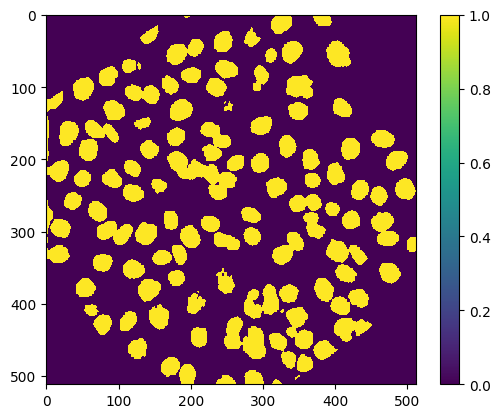

Label


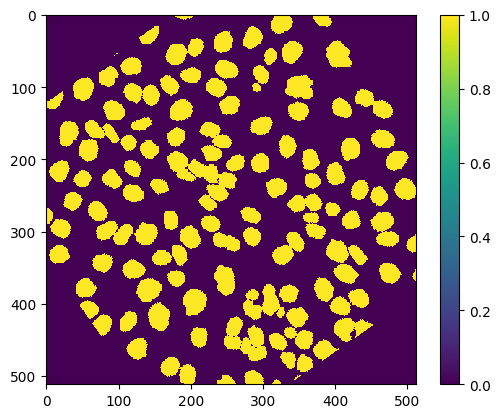

original image


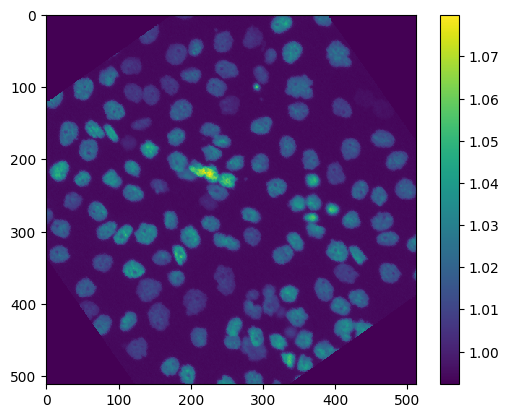

In [28]:
data, label = val_dataset[42]
data = data.to(device)
label = label.to(device)


lightning_model.eval()
with torch.no_grad():
    output = lightning_model(data.unsqueeze(dim = 0))
    model_return_numpy = channel_comparison(output.cpu())
    print('Model output')
    plot_heatmap(model_return_numpy)
    print('Label')
    plot_heatmap(label.cpu().squeeze().numpy())
    print('original image')
    plot_heatmap(data.cpu().squeeze().numpy())

In [30]:
torch.save(lightning_model.state_dict(), convert_backslashes_to_forward_slashes(r'C:\Users\Komputer\Documents\Hackaton_heidelberg\CellTrackingU-Net\saved_models\BIG_model'))